In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
#pip install xarray==v2023.06.0
import xarray as xr
from scipy import stats
from scipy import integrate
from numpy import exp
import math

from osgeo import gdal
import pyhdf
from pyhdf.SD import SD
import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
## set the line width of the hatch
mpl.rcParams['hatch.linewidth'] = 0.5
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
import matplotlib.ticker as mticker

## mask forest and crop

In [2]:
## monthly, taiwan already excluded
ds_lai = xr.open_dataset('/portal1/dell/li-b/multiregression/lai1.nc').sel(time=slice('2002-07-31', '2022-12-31'))
ds_ndvi = xr.open_dataset('/portal1/dell/li-b/multiregression/ndvi1.nc').sel(time=slice('2002-07-01', '2022-12-01'))

ds_pre = xr.open_dataset('/portal1/dell/li-b/multiregression/pre1.nc').sel(time=slice('2002-07-31', '2022-12-31'))
ds_vpd = xr.open_dataset('/portal1/dell/li-b/multiregression/vpd1.nc').sel(time=slice('2002-07-31', '2022-12-31'))
ds_sm = xr.open_dataset('/portal1/dell/li-b/multiregression/sm1.nc').sel(time=slice('2015-04-30', '2022-09-30'))
ds_rn = xr.open_dataset('/portal1/dell/li-b/multiregression/rn1.nc').sel(time=slice('2002-07-31', '2022-12-31'))

In [2]:
## 789 anos
ds_lai = xr.open_dataset('/portal1/dell/li-b/multiregression/lai.nc').sel(time=slice('2002-07-31', '2022-07-31'))
ds_ndvi = xr.open_dataset('/portal1/dell/li-b/multiregression/ndvi.nc').sel(time=slice('2002-07-01', '2022-07-01'))

ds_pre = xr.open_dataset('/portal1/dell/li-b/multiregression/pre.nc').sel(time=slice('2002-07-31', '2022-07-31'))
ds_vpd = xr.open_dataset('/portal1/dell/li-b/multiregression/vpd.nc').sel(time=slice('2002-07-31', '2022-07-31'))
ds_sm = xr.open_dataset('/portal1/dell/li-b/multiregression/sm.nc').sel(time=slice('2015-07-31', '2022-07-31'))
ds_rn = xr.open_dataset('/portal1/dell/li-b/multiregression/rn.nc').sel(time=slice('2002-07-31', '2022-07-31'))

In [14]:
ds_sif = xr.open_dataset('/portal1/dell/li-b/multiregression/sif.nc').sel(time=slice('2002-07-31', '2022-07-31'))

In [15]:
ds_sif1 = varimask_forest(ds_sif)
ds_sif2 = varimask_crop(ds_sif)

In [3]:
def varimask_forest(ds):
    mask = xr.open_dataset('/portal1/dell/li-b/multiregression/LC_IGBP_2022_epsg4326.tif')

    x = ds.dims['lon']
    y = ds.dims['lat']
    qc_a = mask['band_data'].sel(band=1).values
    qc_b = np.zeros((y, x), dtype=bool)
    qc_b = (qc_a==1) | (qc_a == 2) | (qc_a == 4) | (qc_a == 5)
    anos = np.zeros_like(ds['vari'].values)
    for t in range(0,ds_lai.dims['time']):    #### change the time length
        vari_a = ds['vari'][t,:,:].values
        vari_b = np.zeros((y, x))
        vari_b = np.where(qc_b, vari_a, np.nan)
        arr = vari_b.copy()##### exclude sichuan mountaions 
        arr[:80,:51] = np.nan
        anos[t,:,:] = arr
        
    ds_ex = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                                coords={ 'time': (['time'], ds.time.values),
                                        'lat': (['lat'], ds.lat.values),
                                        'lon': (['lon'], ds.lon.values)})
        
    return(ds_ex)

ds_lai1 = varimask_forest(ds_lai)
ds_ndvi1 = varimask_forest(ds_ndvi)

ds_pre1 = varimask_forest(ds_pre)
ds_vpd1 = varimask_forest(ds_vpd)
ds_rn1 = varimask_forest(ds_rn)

def varimask_forest1(ds):
    mask = xr.open_dataset('/portal1/dell/li-b/multiregression/LC_IGBP_2022_epsg4326.tif')

    x = ds.dims['lon']
    y = ds.dims['lat']
    qc_a = mask['band_data'].sel(band=1).values
    qc_b = np.zeros((y, x), dtype=bool)
    qc_b = (qc_a==1) | (qc_a == 2) | (qc_a == 4) | (qc_a == 5)
    anos = np.zeros_like(ds['vari'].values)
    for t in range(0,ds_sm.dims['time']):  ########## change the time length    
        vari_a = ds['vari'][t,:,:].values
        vari_b = np.zeros((y, x))
        vari_b = np.where(qc_b, vari_a, np.nan)
        arr = vari_b.copy()##### exclude sichuan mountaions 
        arr[:80,:51] = np.nan
        anos[t,:,:] = arr
        
    ds_ex = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                                coords={ 'time': (['time'], ds.time.values),
                                        'lat': (['lat'], ds.lat.values),
                                        'lon': (['lon'], ds.lon.values)})
        
    return(ds_ex)

ds_sm1 = varimask_forest1(ds_sm)

In [4]:
def varimask_crop(ds):
    mask = xr.open_dataset('/portal1/dell/li-b/multiregression/LC_IGBP_2022_epsg4326.tif')

    x = ds.dims['lon']
    y = ds.dims['lat']
    qc_a = mask['band_data'].sel(band=1).values
    qc_b = np.zeros((y, x), dtype=bool)
    qc_b = (qc_a == 12) | (qc_a == 14)
    anos = np.zeros_like(ds['vari'].values)
    for t in range(0,ds_lai.dims['time']):    
        vari_a = ds['vari'][t,:,:].values
        vari_b = np.zeros((y, x))
        vari_b = np.where(qc_b, vari_a, np.nan)
        anos[t,:,:] = vari_b
        
    ds_ex = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                                coords={ 'time': (['time'], ds.time.values),
                                        'lat': (['lat'], ds.lat.values),
                                        'lon': (['lon'], ds.lon.values)})
        
    return(ds_ex)

ds_lai2 = varimask_crop(ds_lai)
ds_ndvi2 = varimask_crop(ds_ndvi)

ds_pre2 = varimask_crop(ds_pre)
ds_vpd2 = varimask_crop(ds_vpd)
ds_rn2 = varimask_crop(ds_rn)

def varimask_crop1(ds):
    mask = xr.open_dataset('/portal1/dell/li-b/multiregression/LC_IGBP_2022_epsg4326.tif')

    x = ds.dims['lon']
    y = ds.dims['lat']
    qc_a = mask['band_data'].sel(band=1).values
    qc_b = np.zeros((y, x), dtype=bool)
    qc_b = (qc_a == 12) | (qc_a == 14)
    anos = np.zeros_like(ds['vari'].values)
    for t in range(0,ds_sm.dims['time']):    
        vari_a = ds['vari'][t,:,:].values
        vari_b = np.zeros((y, x))
        vari_b = np.where(qc_b, vari_a, np.nan)
        anos[t,:,:] = vari_b
        
    ds_ex = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                                coords={ 'time': (['time'], ds.time.values),
                                        'lat': (['lat'], ds.lat.values),
                                        'lon': (['lon'], ds.lon.values)})
        
    return(ds_ex)

ds_sm2 = varimask_crop1(ds_sm)

## scatter plots

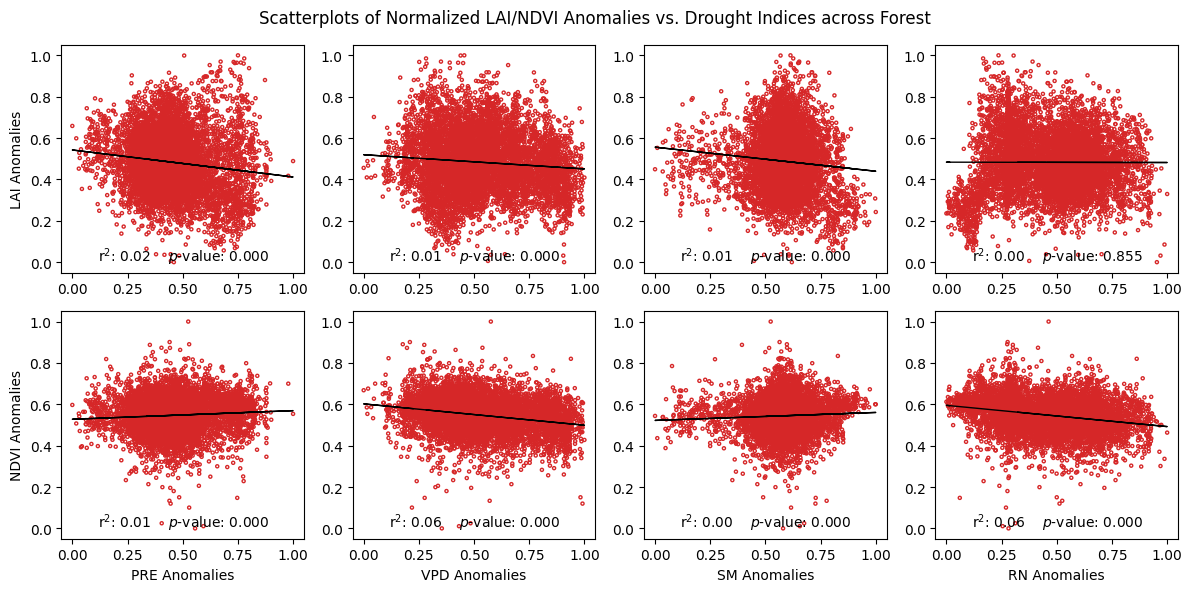

In [16]:
import statsmodels
from sklearn.preprocessing import MinMaxScaler
fig, axes = plt.subplots(2, 4, figsize=(12, 6))  # 1 row, 2 columns

y1 = ds_lai1['vari'][20,:,:].values.ravel()
y2 = ds_ndvi1['vari'][20,:,:].values.ravel()
x0 = ds_pre1['vari'][20,:,:].values.ravel()
x1 = ds_vpd1['vari'][20,:,:].values.ravel()
x2 = ds_sm1['vari'][7,:,:].values.ravel()
x3 = ds_rn1['vari'][20,:,:].values.ravel()
y1[y1>1.5] = np.nan
y2[y2<-0.2] = np.nan

vari_dict = {'x0': x0, 'x1': x1, 'x2': x2, 'x3': x3}
for i in range(0,4):
    x_axis0 = vari_dict[f'x{i}']
    x_axis = x_axis0[~np.isnan(y1)]
    x_axis1 = x_axis[~np.isnan(x_axis)]
    y_axis = y1[~np.isnan(x_axis0)]
    y_axis1 = y_axis[~np.isnan(y_axis)]
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x_axis1.reshape(-1, 1)).flatten()
    y = scaler.fit_transform(y_axis1.reshape(-1, 1)).flatten()
    res = stats.linregress(x, y)
    axes[0,i].plot(x, res.intercept+res.slope*x, color='black', linestyle='-', lw=1)
    axes[0,i].text(0.15, 0.05, f"r$^2$: {res.rvalue**2:.2f}    $p$-value: {res.pvalue:.3f}", transform=axes[0,i].transAxes)
    axes[0,i].scatter(x, y, s=5, facecolors='none', edgecolors='tab:red')

for i in range(0,4):
    x_axis0 = vari_dict[f'x{i}']
    x_axis = x_axis0[~np.isnan(y2)]
    x_axis1 = x_axis[~np.isnan(x_axis)]
    y_axis = y2[~np.isnan(x_axis0)]
    y_axis1 = y_axis[~np.isnan(y_axis)]
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x_axis1.reshape(-1, 1)).flatten()
    y = scaler.fit_transform(y_axis1.reshape(-1, 1)).flatten()
    res = stats.linregress(x, y)
    axes[1,i].plot(x, res.intercept+res.slope*x, color='black', linestyle='-', lw=1)
    axes[1,i].text(0.15, 0.05, f"r$^2$: {res.rvalue**2:.2f}    $p$-value: {res.pvalue:.3f}", transform=axes[1,i].transAxes)
    axes[1,i].scatter(x, y, s=5, facecolors='none', edgecolors='tab:red')
    # axes[1,i].set_ylim(-0.15,)
    
axes[0,0].set_ylabel('LAI Anomalies')
axes[1,0].set_xlabel('PRE Anomalies')
axes[1,0].set_ylabel('NDVI Anomalies')
axes[1,1].set_xlabel('VPD Anomalies')
axes[1,2].set_xlabel('SM Anomalies')
axes[1,3].set_xlabel('RN Anomalies')
fig.suptitle('Scatterplots of Normalized LAI/NDVI Anomalies vs. Drought Indices across Forest')
plt.tight_layout()
plt.show()

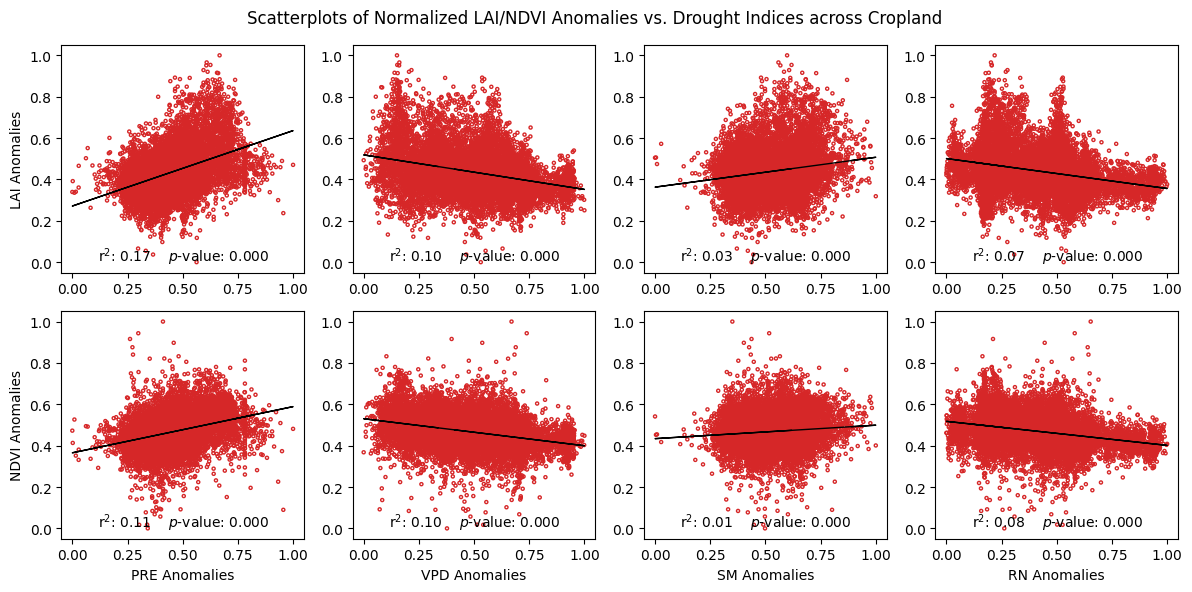

In [18]:
import statsmodels
from sklearn.preprocessing import MinMaxScaler
fig, axes = plt.subplots(2, 4, figsize=(12, 6))  # 1 row, 2 columns

y1 = ds_lai2['vari'][20,:,:].values.ravel()
y2 = ds_ndvi2['vari'][20,:,:].values.ravel()
x0 = ds_pre2['vari'][20,:,:].values.ravel()
x1 = ds_vpd2['vari'][20,:,:].values.ravel()
x2 = ds_sm2['vari'][7,:,:].values.ravel()
x3 = ds_rn2['vari'][20,:,:].values.ravel()
y2[y2<-0.3] = np.nan

vari_dict = {'x0': x0, 'x1': x1, 'x2': x2, 'x3': x3}
for i in range(0,4):
    x_axis0 = vari_dict[f'x{i}']
    x_axis = x_axis0[~np.isnan(y1)]
    x_axis1 = x_axis[~np.isnan(x_axis)]
    y_axis = y1[~np.isnan(x_axis0)]
    y_axis1 = y_axis[~np.isnan(y_axis)]
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x_axis1.reshape(-1, 1)).flatten()
    y = scaler.fit_transform(y_axis1.reshape(-1, 1)).flatten()
    res = stats.linregress(x, y)
    axes[0,i].plot(x, res.intercept+res.slope*x, color='black', linestyle='-', lw=1)
    axes[0,i].text(0.15, 0.05, f"r$^2$: {res.rvalue**2:.2f}    $p$-value: {res.pvalue:.3f}", transform=axes[0,i].transAxes)
    axes[0,i].scatter(x, y, s=5, facecolors='none', edgecolors='tab:red')

for i in range(0,4):
    x_axis0 = vari_dict[f'x{i}']
    x_axis = x_axis0[~np.isnan(y2)]
    x_axis1 = x_axis[~np.isnan(x_axis)]
    y_axis = y2[~np.isnan(x_axis0)]
    y_axis1 = y_axis[~np.isnan(y_axis)]
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x_axis1.reshape(-1, 1)).flatten()
    y = scaler.fit_transform(y_axis1.reshape(-1, 1)).flatten()
    res = stats.linregress(x, y)
    axes[1,i].plot(x, res.intercept+res.slope*x, color='black', linestyle='-', lw=1)
    axes[1,i].text(0.15, 0.05, f"r$^2$: {res.rvalue**2:.2f}    $p$-value: {res.pvalue:.3f}", transform=axes[1,i].transAxes)
    axes[1,i].scatter(x, y, s=5, facecolors='none', edgecolors='tab:red')
    # axes[1,i].set_ylim(-0.15,)
    
axes[0,0].set_ylabel('LAI Anomalies')
axes[1,0].set_xlabel('PRE Anomalies')
axes[1,0].set_ylabel('NDVI Anomalies')
axes[1,1].set_xlabel('VPD Anomalies')
axes[1,2].set_xlabel('SM Anomalies')
axes[1,3].set_xlabel('RN Anomalies')
fig.suptitle('Scatterplots of Normalized LAI/NDVI Anomalies vs. Drought Indices across Cropland')
plt.tight_layout()
plt.show()

## seasonality

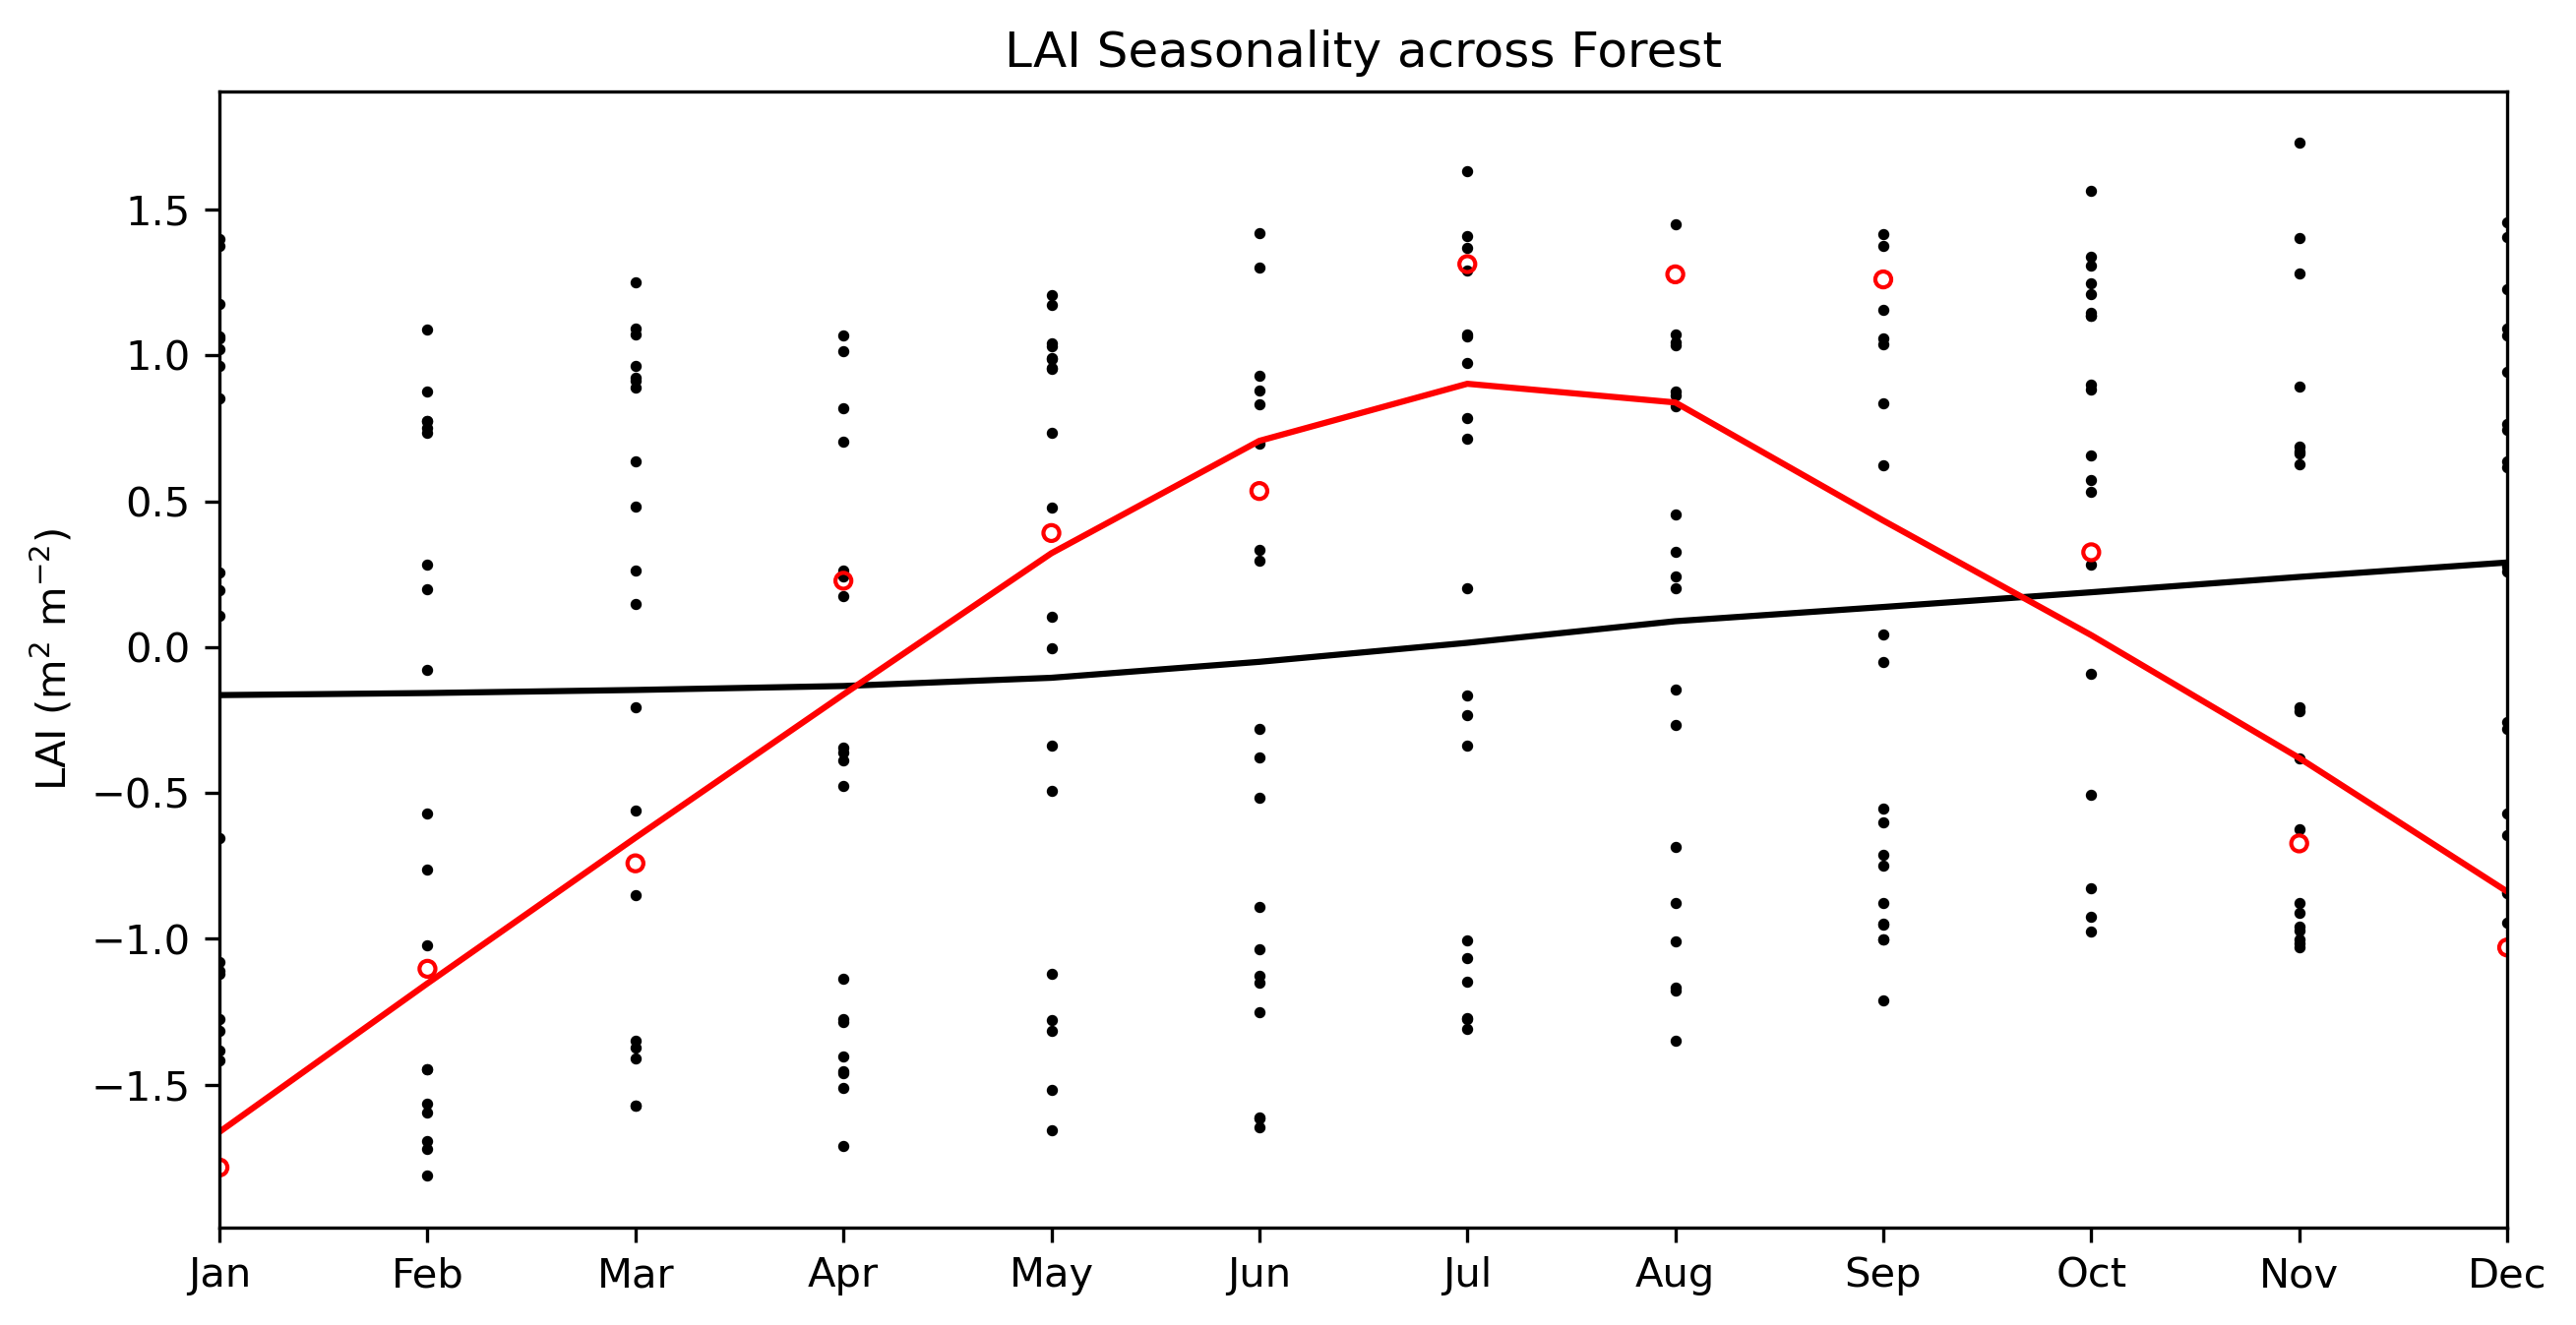

In [143]:
dflai = ds_lai1['vari'].mean(dim=['lat','lon'],skipna=True).values
dfndvi = ds_ndvi1['vari'].mean(dim=['lat','lon'],skipna=True).values

times = pd.date_range('2002-07-31','2022-12-31',freq='M')
df1 = pd.DataFrame({'time':times,'lai':dflai,'ndvi':dfndvi})
df1.set_index('time', inplace=True)
df2 = df1.loc['2003-01-31':'2021-12-31']
df3 = df1.loc['2022-01-31':'2022-12-31']
lai = df2['lai'].values.reshape(12,-1)
lai2022 = df3['lai'].values.reshape(12,-1)

fig, ax = plt.subplots(1,1,dpi=300,figsize=(10,5))
time = np.arange(1,13)
from matplotlib import markers
from statsmodels.nonparametric.smoothers_lowess import lowess

smoothed_lines = []
for i in range(0,lai.shape[1]):
    mu = np.mean(lai[:,i])
    sigma = np.std(lai[:,i])
    standardized_lai = (lai[:,i] - mu) / sigma
    smoothed = lowess(standardized_lai, time, frac=0.8)
    smoothed_lines.append(smoothed)
for i in range(0,lai.shape[1]):
    mu = np.mean(lai[:,i])
    sigma = np.std(lai[:,i])
    standardized_lai = (lai[:,i] - mu) / sigma
    ax.scatter(time, standardized_lai, color='black', s=3)
smoothed_mean = np.mean([line[:, 1] for line in smoothed_lines], axis=0)
ax.plot(time, smoothed_mean, color='black', label='LOESS fit')
# smoothed_std = np.std([line[:, 1] for line in smoothed_lines], axis=0)
# confidence_interval_upper = smoothed_mean + 1.96 * smoothed_std
# confidence_interval_lower = smoothed_mean - 1.96 * smoothed_std
# ax.fill_between(time, confidence_interval_lower, confidence_interval_upper, color='gray', alpha=0.4, linewidth=0, label='95% Confidence Intervals')

mu = np.mean(lai2022[:,0])
sigma = np.std(lai2022[:,0])
standardized_lai = (lai2022[:,0] - mu) / sigma
ax.scatter(time, standardized_lai,s=15, marker='o', facecolors='none', edgecolors='r',label='2022')
smoothed = lowess(standardized_lai, time, frac=0.8)
ax.plot(smoothed[:, 0], smoothed[:, 1], color='r', label='LOESS fit')
# smoothed_std = np.std(smoothed[:, 1], axis=0)
# confidence_interval_upper = smoothed[:,1] + 1.96 * smoothed_std
# confidence_interval_lower = smoothed[:,1] - 1.96 * smoothed_std
# ax.fill_between(time, confidence_interval_lower, confidence_interval_upper, color='gray', alpha=0.2,linewidth=0, label='95% Confidence Intervals')


ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax.set_ylabel('LAI (m$^2$ m$^{-2}$)')
ax.set_xlim(time[0],time[-1])
ax.set_title('LAI Seasonality across Forest')
# ax.legend()
plt.show()

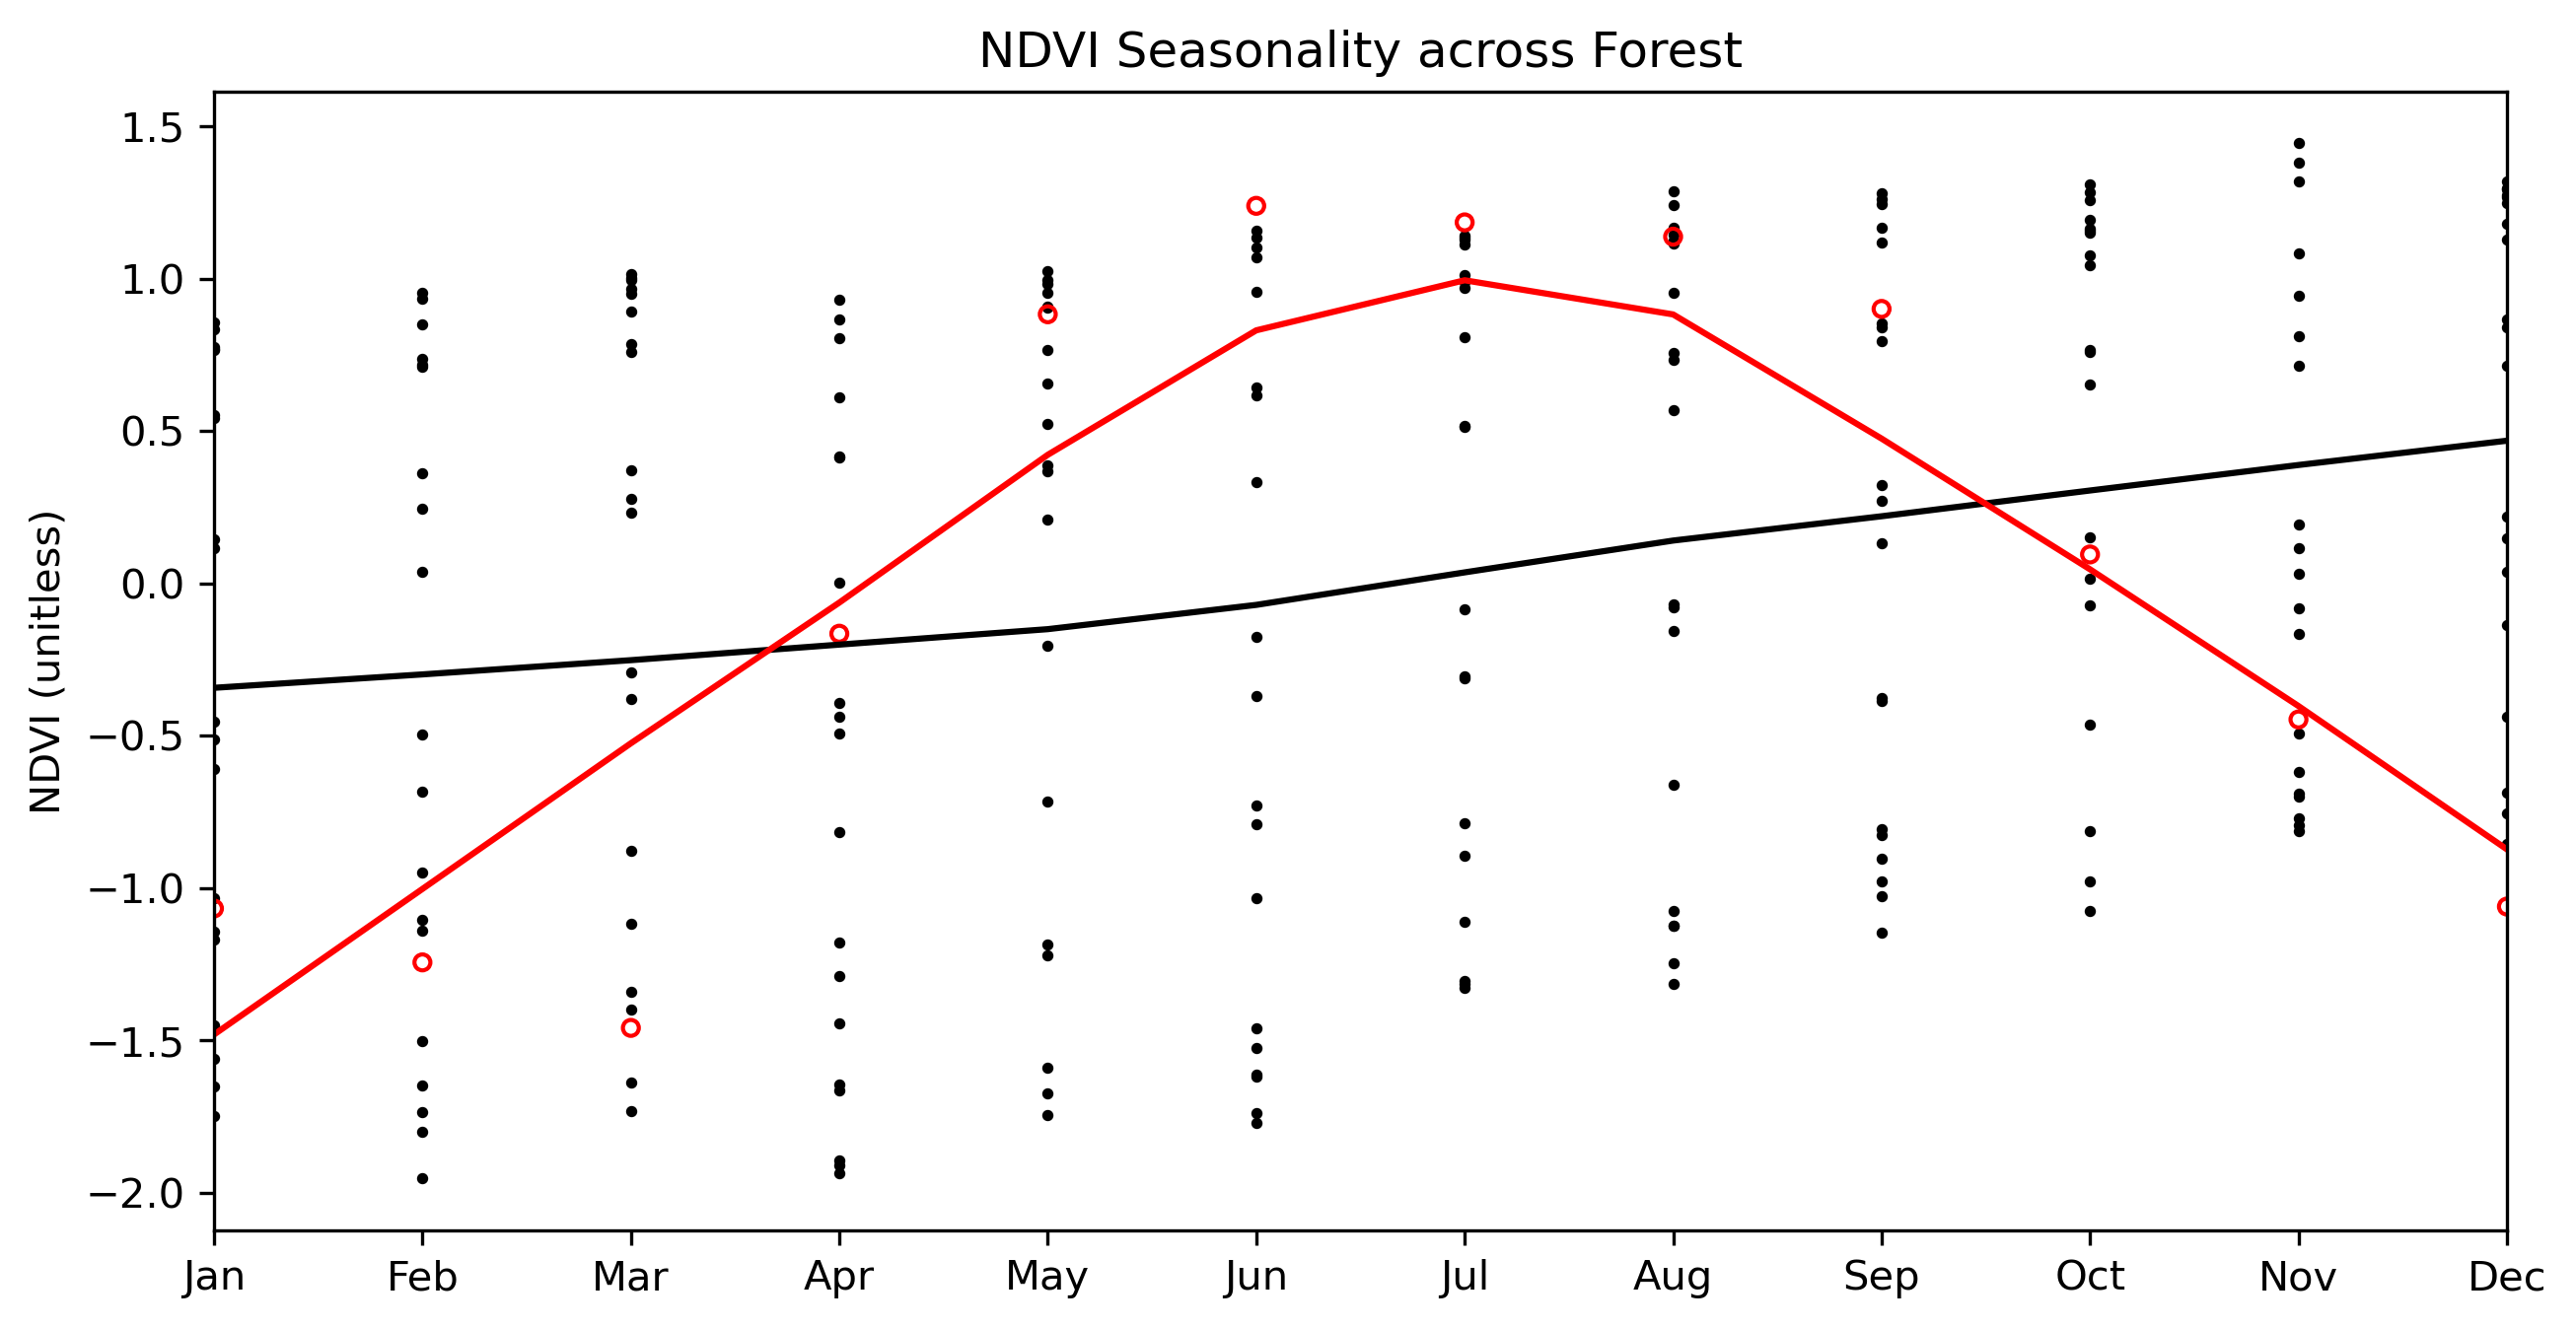

In [144]:
dflai = ds_lai1['vari'].mean(dim=['lat','lon'],skipna=True).values
dfndvi = ds_ndvi1['vari'].mean(dim=['lat','lon'],skipna=True).values

times = pd.date_range('2002-07-31','2022-12-31',freq='M')
df1 = pd.DataFrame({'time':times,'lai':dflai,'ndvi':dfndvi})
df1.set_index('time', inplace=True)
df2 = df1.loc['2003-01-31':'2021-12-31']
df3 = df1.loc['2022-01-31':'2022-12-31']
lai = df2['ndvi'].values.reshape(12,-1)
lai2022 = df3['ndvi'].values.reshape(12,-1)

fig, ax = plt.subplots(1,1,dpi=300,figsize=(10,5))
time = np.arange(1,13)
from statsmodels.nonparametric.smoothers_lowess import lowess

smoothed_lines = []
for i in range(0,lai.shape[1]):
    mu = np.mean(lai[:,i])
    sigma = np.std(lai[:,i])
    standardized_lai = (lai[:,i] - mu) / sigma
    smoothed = lowess(standardized_lai, time, frac=0.8)
    smoothed_lines.append(smoothed)
for i in range(0,lai.shape[1]):
    mu = np.mean(lai[:,i])
    sigma = np.std(lai[:,i])
    standardized_lai = (lai[:,i] - mu) / sigma
    ax.scatter(time, standardized_lai, color='black', s=3)
smoothed_mean = np.mean([line[:, 1] for line in smoothed_lines], axis=0)
ax.plot(time, smoothed_mean, color='black', label='LOESS fit')

mu = np.mean(lai2022[:,0])
sigma = np.std(lai2022[:,0])
standardized_lai = (lai2022[:,0] - mu) / sigma
ax.scatter(time, standardized_lai,s=15, marker='o', facecolors='none', edgecolors='r',label='2022')
smoothed = lowess(standardized_lai, time, frac=0.8)
ax.plot(smoothed[:, 0], smoothed[:, 1], color='r', label='LOESS fit')


ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax.set_ylabel('NDVI (unitless)')
ax.set_xlim(time[0],time[-1])
ax.set_title('NDVI Seasonality across Forest')
# ax.legend()
plt.show()

##  monthly lai & ndvi relationship

Text(0.5, 1.0, 'Relationship between Normalized NDVI and Normalized LAI across Forest')

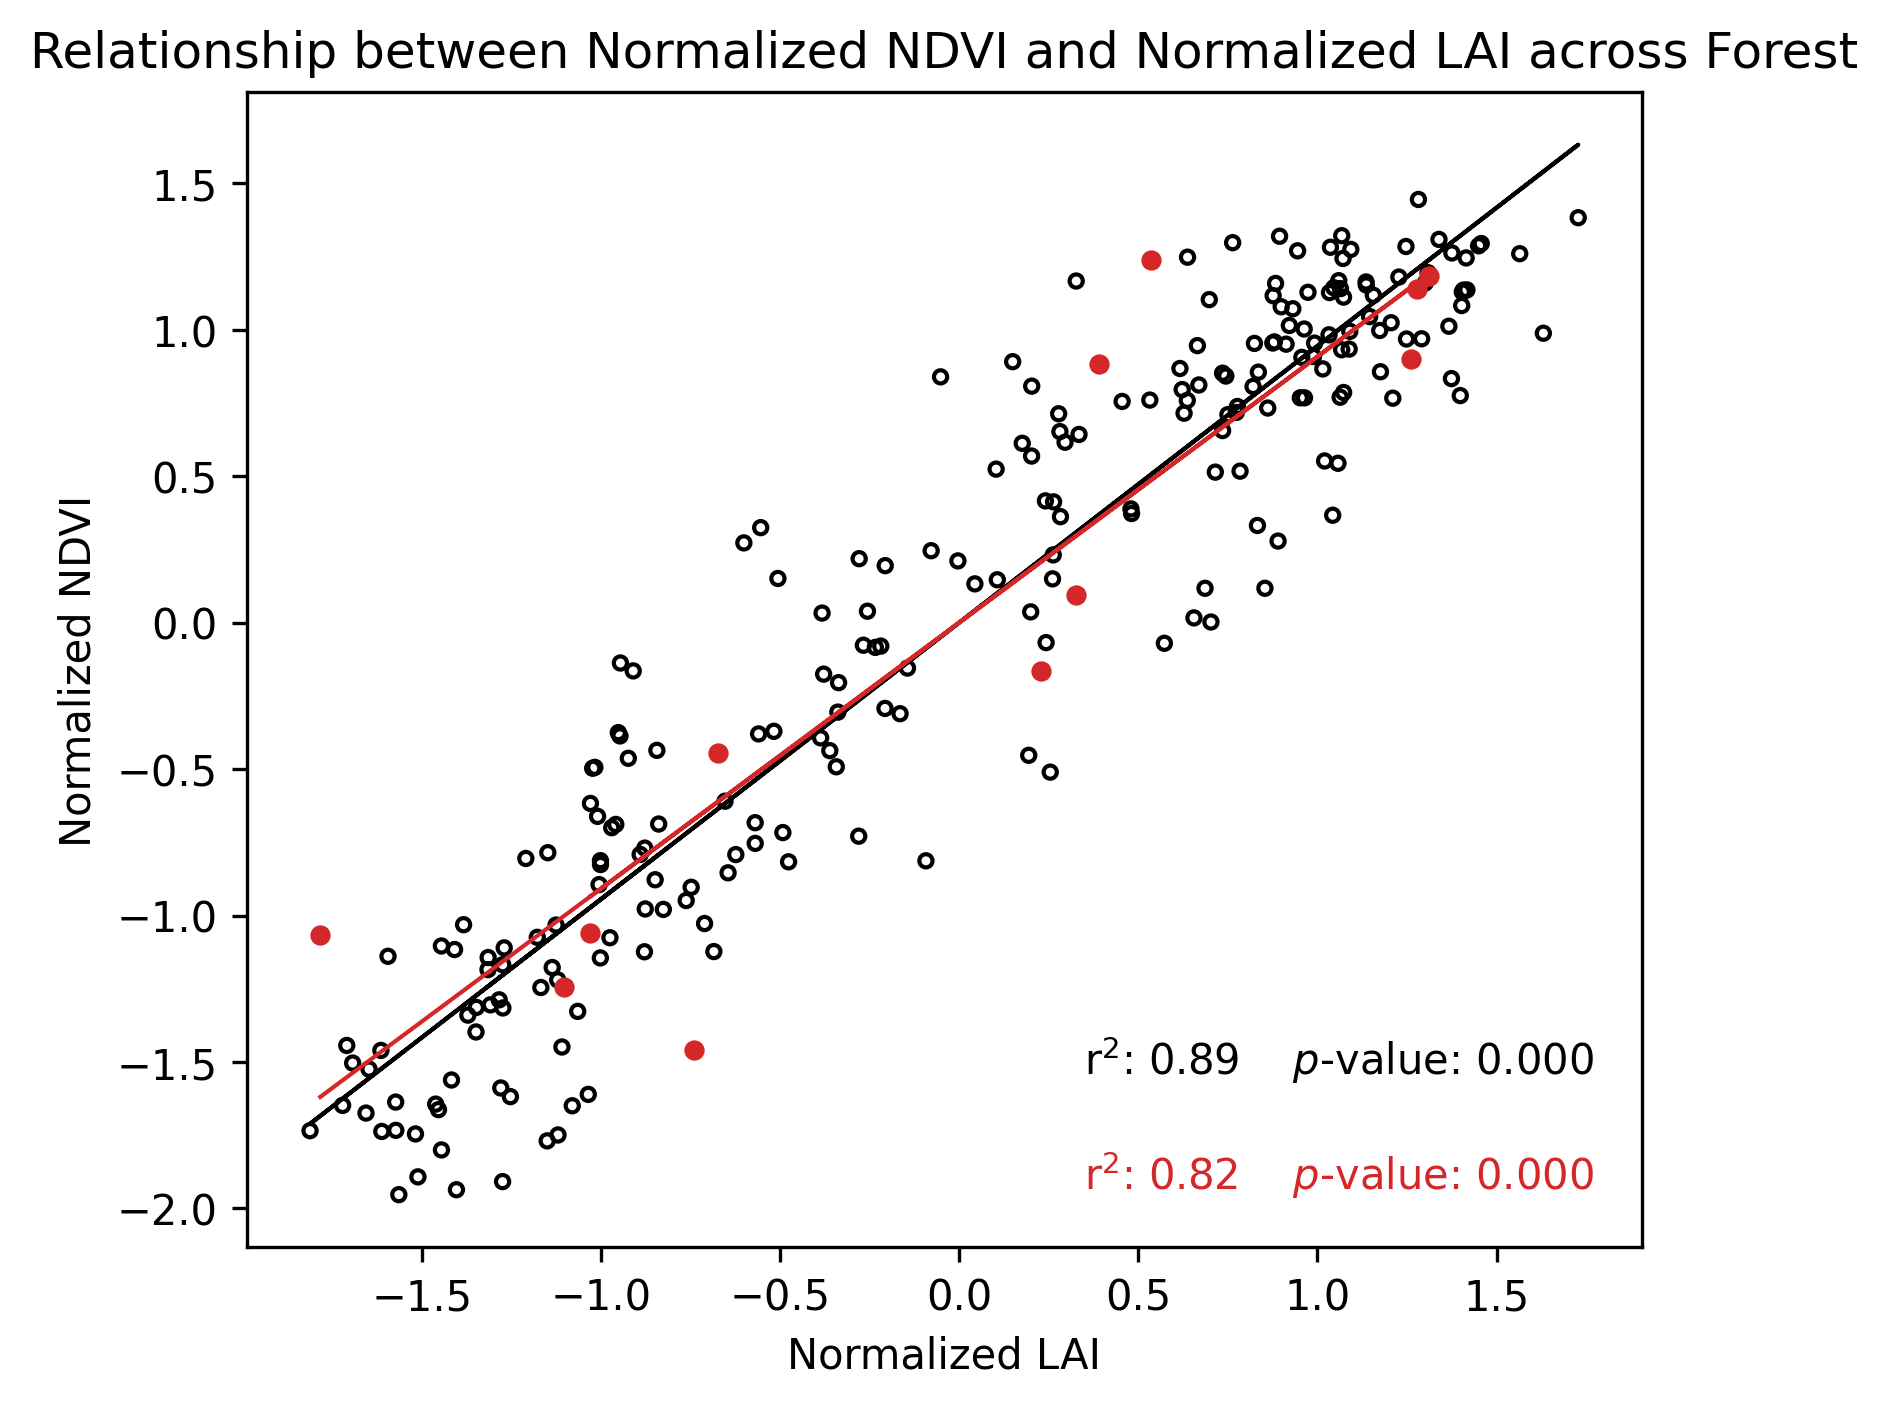

In [7]:
from sklearn.preprocessing import StandardScaler
dflai = ds_lai1['vari'].mean(dim=['lat','lon'],skipna=True).values
dfndvi = ds_ndvi1['vari'].mean(dim=['lat','lon'],skipna=True).values

times = pd.date_range('2002-07-31','2022-12-31',freq='M')
df1 = pd.DataFrame({'time':times,'lai':dflai,'ndvi':dfndvi})
df1.set_index('time', inplace=True)
df2 = df1.loc['2003-01-31':'2021-12-31']
df3 = df1.loc['2022-01-31':'2022-12-31']
lai = df2['lai'].values.reshape(12,-1)
lai2022 = df3['lai'].values.reshape(12,-1)
ndvi = df2['ndvi'].values.reshape(12,-1)
ndvi2022 = df3['ndvi'].values.reshape(12,-1)

scaler = StandardScaler()
lai_sta = np.zeros_like(lai)
ndvi_sta = np.zeros_like(ndvi)
for i in range(0,lai.shape[1]):
    lai_sta[:,i] = scaler.fit_transform(lai[:,i].reshape(-1, 1)).flatten()
    ndvi_sta[:,i] = scaler.fit_transform(ndvi[:,i].reshape(-1, 1)).flatten()

lai2022_sta = scaler.fit_transform(lai2022.reshape(-1, 1)).flatten()
ndvi2022_sta = scaler.fit_transform(ndvi2022.reshape(-1, 1)).flatten()

fig, ax = plt.subplots(1,1,dpi=300,figsize=(6,5))
plt.scatter(lai_sta.ravel(), ndvi_sta.ravel(), s=10, facecolors='none', edgecolors='black')
plt.scatter(lai2022_sta.ravel(), ndvi2022_sta.ravel(), s=15, color='tab:red')
x = lai_sta.ravel()
y = ndvi_sta.ravel()
res = stats.linregress(x, y)
plt.plot(x, res.intercept+res.slope*x, color='black', linestyle='-', lw=1)
plt.text(0.6, 0.15, f"r$^2$: {res.rvalue**2:.2f}    $p$-value: {res.pvalue:.3f}", transform=ax.transAxes)
x = lai2022_sta.ravel()
y = ndvi2022_sta.ravel()
res = stats.linregress(x, y)
plt.plot(x, res.intercept+res.slope*x, color='tab:red', linestyle='-', lw=1)
plt.text(0.6, 0.05, f"r$^2$: {res.rvalue**2:.2f}    $p$-value: {res.pvalue:.3f}", transform=ax.transAxes, color='tab:red')

plt.xlabel('Normalized LAI')
plt.ylabel('Normalized NDVI')
ax.set_title('Relationship between Normalized NDVI and Normalized LAI across Forest')

Text(0.5, 1.0, 'Relationship between Normalized NDVI and Normalized LAI across Cropland')

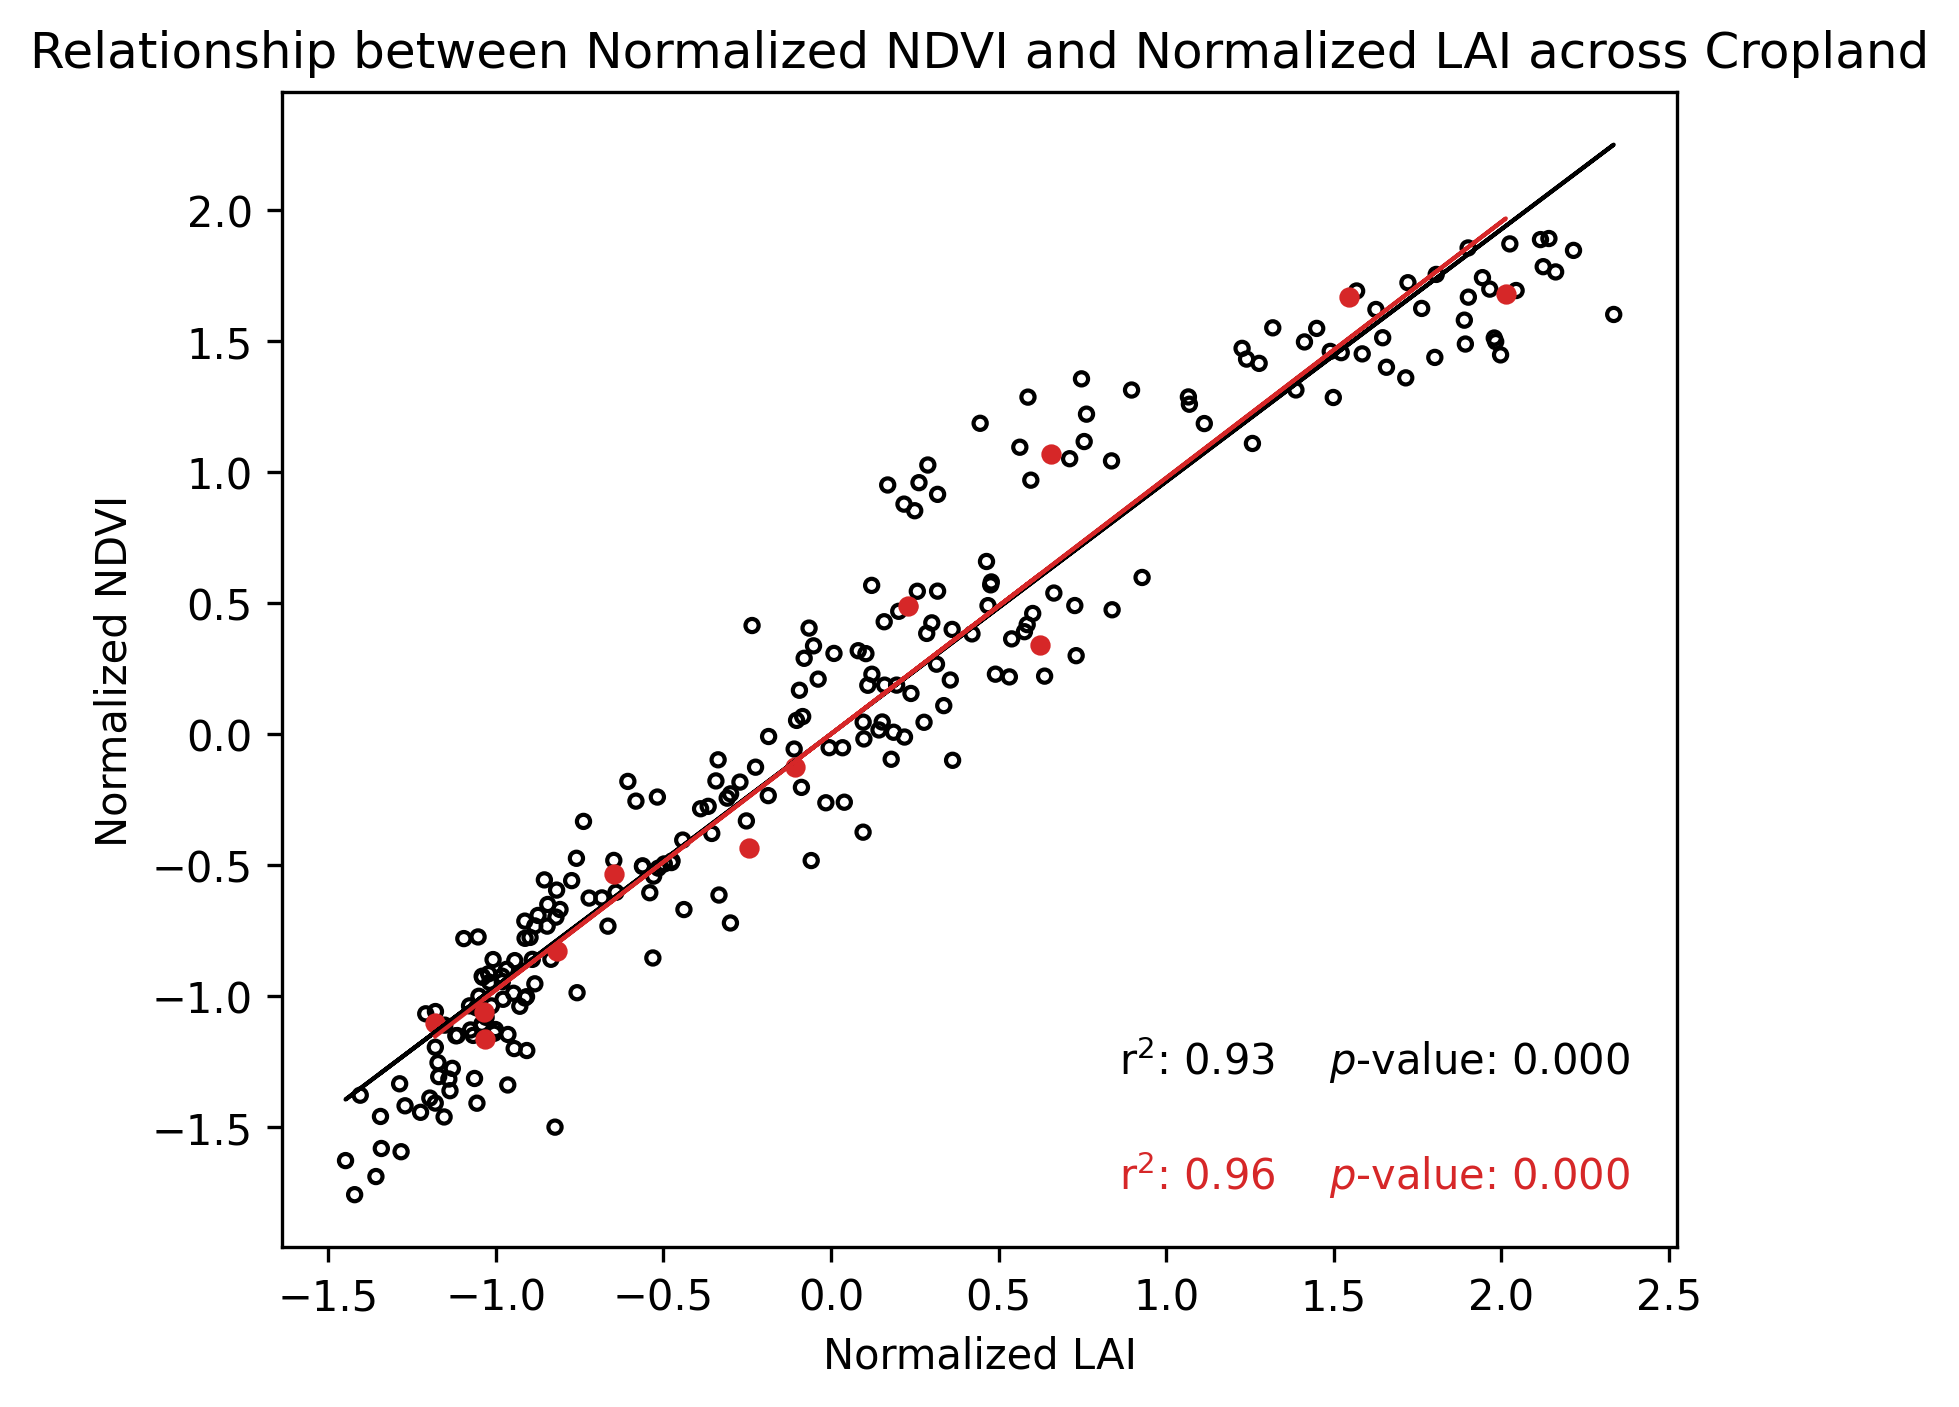

In [6]:
from sklearn.preprocessing import StandardScaler
dflai = ds_lai2['vari'].mean(dim=['lat','lon'],skipna=True).values
dfndvi = ds_ndvi2['vari'].mean(dim=['lat','lon'],skipna=True).values

times = pd.date_range('2002-07-31','2022-12-31',freq='M')
df1 = pd.DataFrame({'time':times,'lai':dflai,'ndvi':dfndvi})
df1.set_index('time', inplace=True)
df2 = df1.loc['2003-01-31':'2021-12-31']
df3 = df1.loc['2022-01-31':'2022-12-31']
lai = df2['lai'].values.reshape(12,-1)
lai2022 = df3['lai'].values.reshape(12,-1)
ndvi = df2['ndvi'].values.reshape(12,-1)
ndvi2022 = df3['ndvi'].values.reshape(12,-1)

scaler = StandardScaler()
lai_sta = np.zeros_like(lai)
ndvi_sta = np.zeros_like(ndvi)
for i in range(0,lai.shape[1]):
    lai_sta[:,i] = scaler.fit_transform(lai[:,i].reshape(-1, 1)).flatten()
    ndvi_sta[:,i] = scaler.fit_transform(ndvi[:,i].reshape(-1, 1)).flatten()

lai2022_sta = scaler.fit_transform(lai2022.reshape(-1, 1)).flatten()
ndvi2022_sta = scaler.fit_transform(ndvi2022.reshape(-1, 1)).flatten()

fig, ax = plt.subplots(1,1,dpi=300,figsize=(6,5))
plt.scatter(lai_sta.ravel(), ndvi_sta.ravel(), s=10, facecolors='none', edgecolors='black')
plt.scatter(lai2022_sta.ravel(), ndvi2022_sta.ravel(), s=15, color='tab:red')
x = lai_sta.ravel()
y = ndvi_sta.ravel()
res = stats.linregress(x, y)
plt.plot(x, res.intercept+res.slope*x, color='black', linestyle='-', lw=1)
plt.text(0.6, 0.15, f"r$^2$: {res.rvalue**2:.2f}    $p$-value: {res.pvalue:.3f}", transform=ax.transAxes)
x = lai2022_sta.ravel()
y = ndvi2022_sta.ravel()
res = stats.linregress(x, y)
plt.plot(x, res.intercept+res.slope*x, color='tab:red', linestyle='-', lw=1)
plt.text(0.6, 0.05, f"r$^2$: {res.rvalue**2:.2f}    $p$-value: {res.pvalue:.3f}", transform=ax.transAxes, color='tab:red')

plt.xlabel('Normalized LAI')
plt.ylabel('Normalized NDVI')
ax.set_title('Relationship between Normalized NDVI and Normalized LAI across Cropland')